**Feature Reduction**

There are a lot of predictors. It seems like some of them might be highly correlated, and that others might have specific problems.

The goal of this notebook is to identify features that can be removed from the dataset:

1. Import the data. 
2. Remove a couple of variables we won't be using, including:
    * id (the ID of the participant)
    * ID (another copy of ID - an artifact of a previous joining of data frames)
    * BIA-BIA_BMI (since we already have a BMI variable as part of the physical group)
    * PCIAT-PCIAT_01 through 20 (which are only used to compute PCIAT_Total)
3. Examining correlations between all predictors and, potentially, removing variables that have extremely high (>0.98) correlation
4. Several groups of variables include a "Season" predictor - e.g., the Season in which the FitnessGram variables were measured. Problematically, the PCIAT (i.e., outcome) variable has its own Season variable, and this doesn't necessarily match any of the other Season values. So, for example, a participant might have had their weight measured in the Spring and their PCIAT score measured in the Fall. We suspect that trying to include the Seasons as (categorical, or dummy variable encoded) predictors will be a bit problematic. However, we will explore interactions between Seasons and associated predictors to determine whether there appears to be a strong interaction between the Season and its associated variables in predicting PCIAT:
    1. For each predictor that is associated with a Season variable (e.g., within the Physical variables), make a scatterplot of the predictor vs. outcome and display regression lines by Season
    2. If there aren't any clear interactions, removing the Season variable from the list of predictors
    3. If there do appear to be interactions, creating dummy variables from the Season variable
5. Export the feature-reduced data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the original data set
train_cleaned = pd.read_csv('train_cleaned_outcome_imputed.csv')
test_cleaned=pd.read_csv('test_cleaned.csv')

In [3]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove all PCIAT component variables from numeric features
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_0').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_1').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_2').columns))

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['sii', 'PCIAT-PCIAT_Total'])

Next, we'll examine correlations between predictors. The goal is to, potentially, eliminate some predictors that are highly correlated.

In [4]:
# Compute absolute value of correlation between variables in numeric_features
correlation_matrix = train_cleaned[numeric_features].corr().abs()

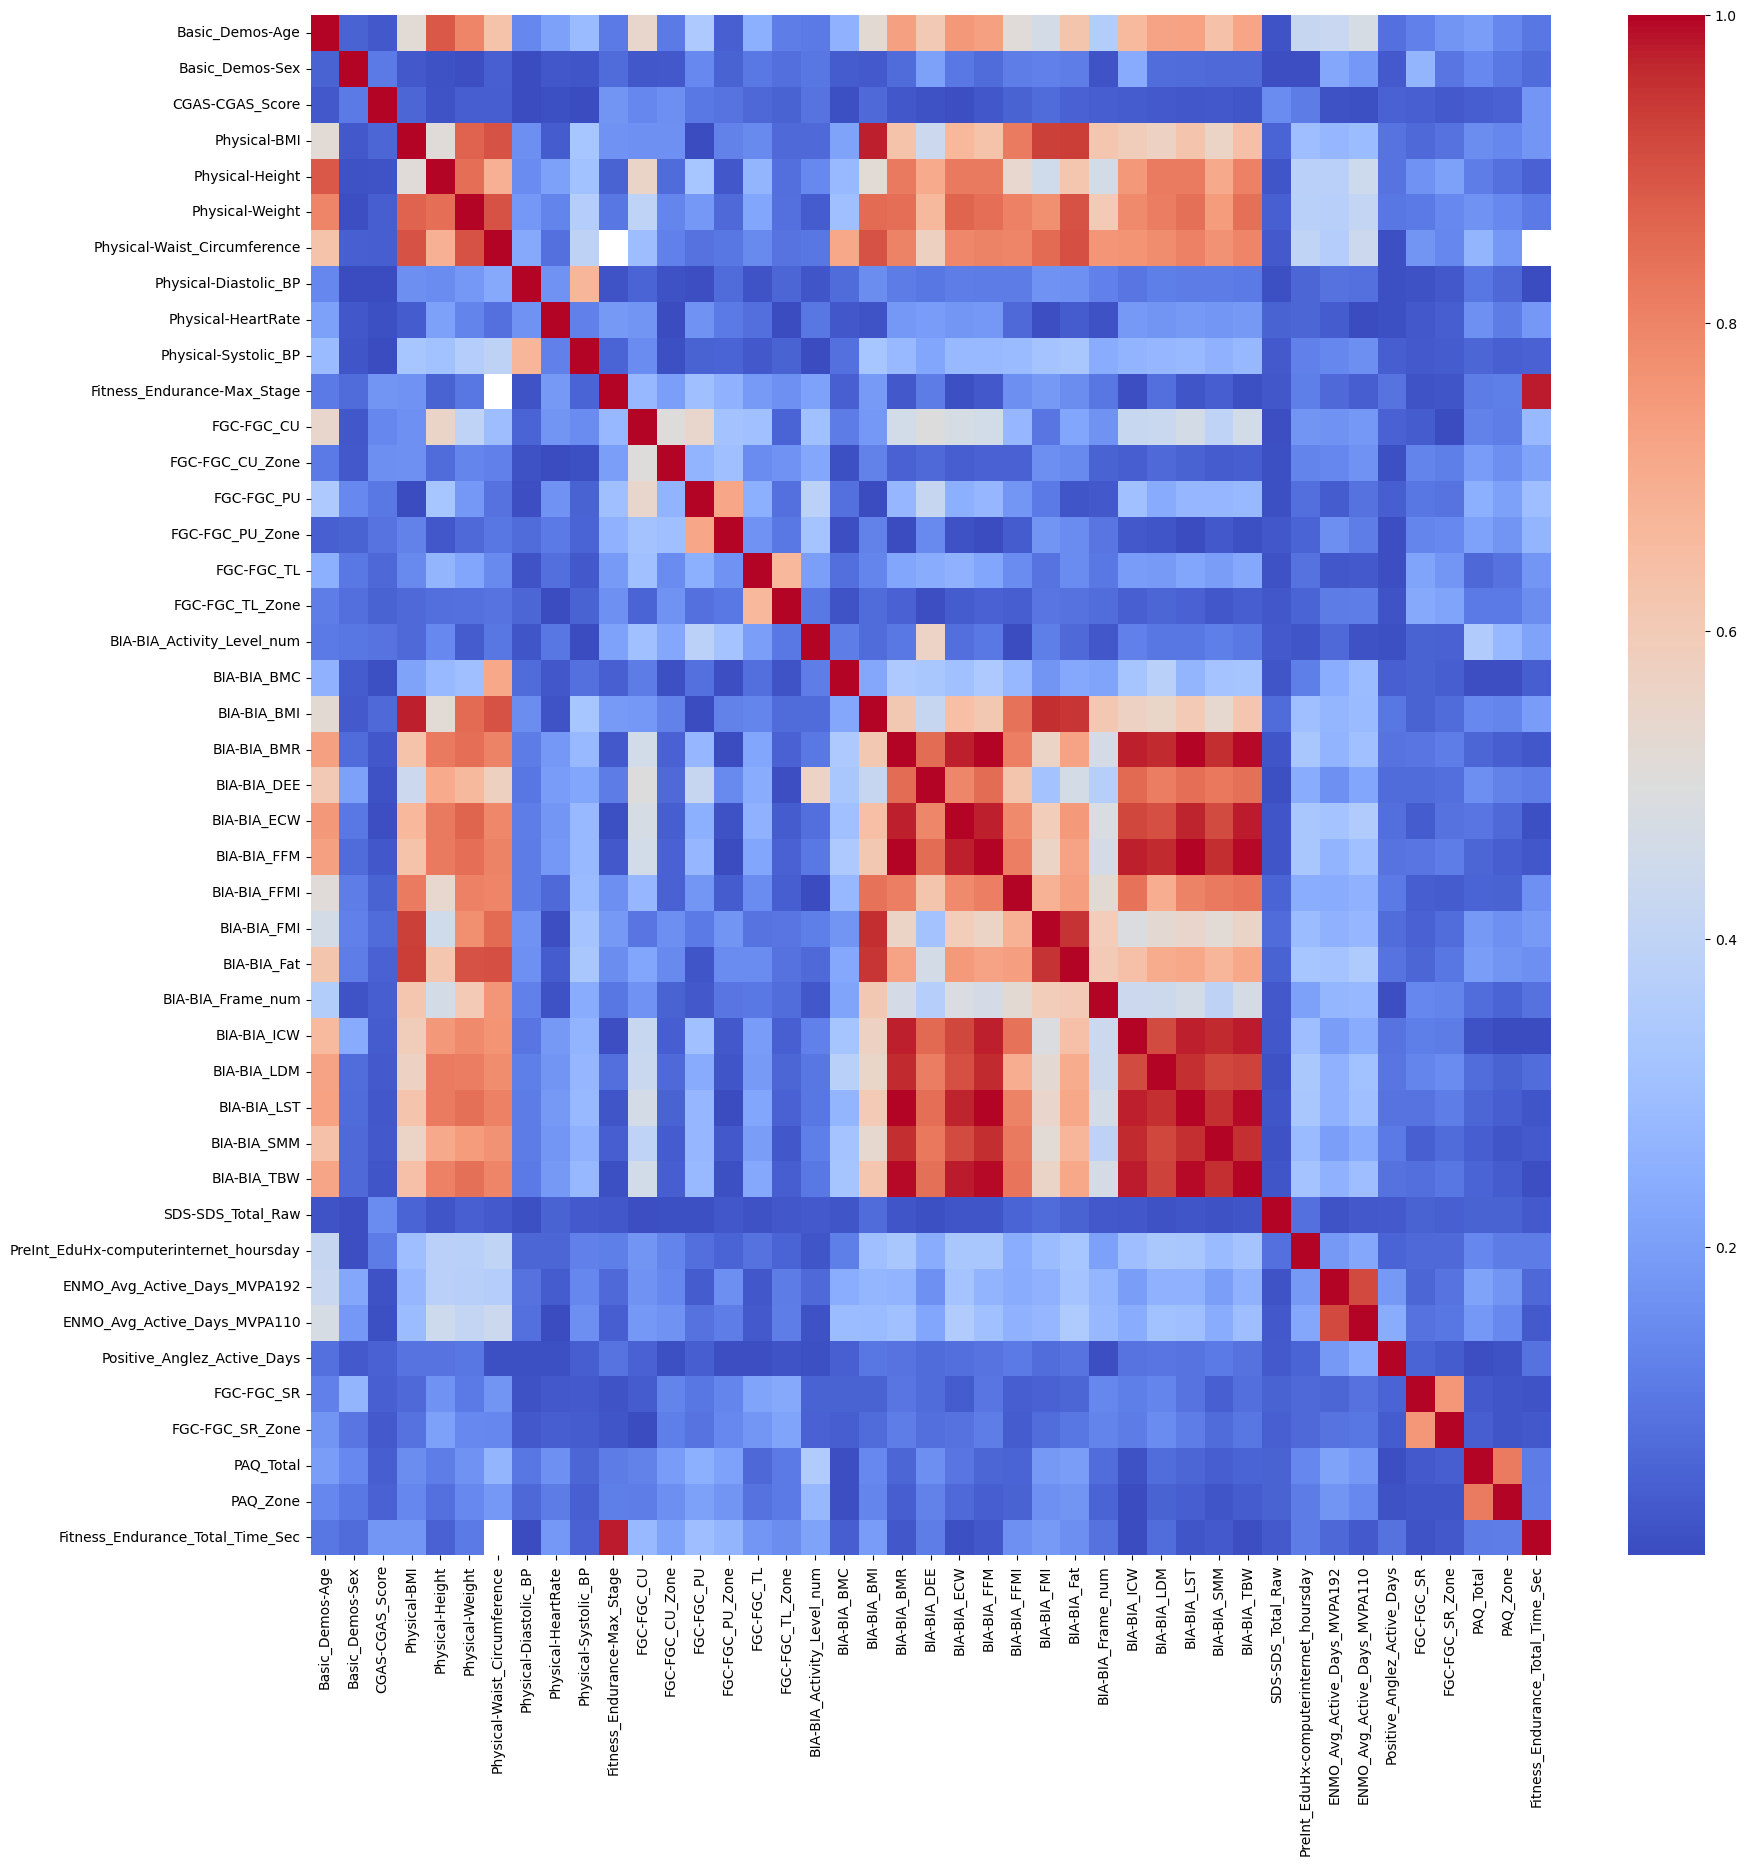

In [5]:
# Create a 20x20 heatmap of correlation_matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [6]:
# List the values in correlation_matrix from largest to smallest, only including values at least 0.85 and less than 1
correlation_matrix = correlation_matrix.unstack()
correlation_matrix = correlation_matrix.sort_values(ascending=False)
correlation_matrix = correlation_matrix[correlation_matrix != 1]
correlation_matrix = correlation_matrix[correlation_matrix >= 0.9]

# Show all values in correlation_matrix without truncating output
pd.set_option('display.max_rows', None)
correlation_matrix

BIA-BIA_BMR                       BIA-BIA_FFM                         1.000000
BIA-BIA_FFM                       BIA-BIA_BMR                         1.000000
BIA-BIA_LST                       BIA-BIA_BMR                         0.996551
BIA-BIA_BMR                       BIA-BIA_LST                         0.996551
BIA-BIA_FFM                       BIA-BIA_LST                         0.996551
BIA-BIA_LST                       BIA-BIA_FFM                         0.996551
BIA-BIA_TBW                       BIA-BIA_BMR                         0.994868
BIA-BIA_BMR                       BIA-BIA_TBW                         0.994868
BIA-BIA_FFM                       BIA-BIA_TBW                         0.994868
BIA-BIA_TBW                       BIA-BIA_FFM                         0.994868
BIA-BIA_LST                       BIA-BIA_TBW                         0.992867
BIA-BIA_TBW                       BIA-BIA_LST                         0.992867
                                  BIA-BIA_ICW       

Some of these predictos are highly correlated. 

**BIA Variable Removal**

Some of the BIA variables appear to either be redundant or computed from each other:
* BIA-BIA_BMI is measuring BMI. It has correlation 0.965105 with Physical_BMI. I can't find any information about how it is any different. It seems likely that BMI varies from day to day and measurement to measurement, so the difference is likely due to measurement error. Going to remove BIA-BIA_BMI

The other BIA variables are:
* BIA-BIA_BMC	Bone Mineral Content
* BIA-BIA_BMR	Basal Metabolic Rate
* BIA-BIA_DEE	Daily Energy Expenditure
* BIA-BIA_LDM	Lean Dry Mass
* BIA-BIA_LST	Lean Soft Tissue
* BIA-BIA_SMM	Skeletal Muscle Mass
* BIA-BIA_FFM	Fat Free Mass
* BIA-BIA_Fat	Body Fat Percentage
* BIA-BIA_Frame_num	Body Frame
* BIA-BIA_TBW	Total Body Water
* BIA-BIA_ECW	Extracellular Water
* BIA-BIA_ICW	Intracellular Water
* BIA-BIA_FMI	Fat Mass Index: Calcuated as FM divided by height squared
* BIA-BIA_FFMI	Fat Free Mass Index: Calcuated as FFM divided by height squared

There exist large correlations between many pairs of these predictors. Below is a list of all pairs with at least 0.99 correlation:
* FFM	BMR	0.9999999999991445
* BMR	TBW	0.9996843922178612
* FFM	TBW	0.9996843882486972
* ECW	BMR	0.99949744961038
* ECW	FFM	0.9994974489820077
* TBW	ECW	0.9994121539401678
* TBW	ICW	0.9989842717508111
* FFM	LDM	0.9989337841842884
* BMR	LDM	0.9989337768885788
* SMM	ICW	0.9984531398777805
* ICW	BMR	0.9981423016493606
* FFM	ICW	0.998142293296351
* ECW	LDM	0.9980088142821305
* TBW	SMM	0.9976684856970098
* TBW	LDM	0.9974587197051186
* ICW	LST	0.9969014072300802
* SMM	BMR	0.996864975676666
* FFM	SMM	0.9968649649869374
* ECW	ICW	0.996852207975357
* LST	SMM	0.9967543066184706
* SMM	ECW	0.9957140182568774
* TBW	LST	0.995487594282981
* BMC	LDM	0.9950199542105168
* LDM	ICW	0.9949518859314233
* ICW	DEE	0.9948088046663506
* DEE	TBW	0.9944107160263206
* DEE	BMR	0.9941186367579632
* DEE	FFM	0.9941186344807962
* LDM	SMM	0.9937473329914341
* LST	BMR	0.9936088620550899
* LST	FFM	0.99360884373626
* DEE	SMM	0.9933843458863473
* LST	ECW	0.9930574064543182
* ECW	DEE	0.992754802616644
* DEE	LDM	0.9919453675327521
* FFM	BMC	0.9914085178617896
* BMR	BMC	0.9914084966327703
* LST	DEE	0.9912776109118937
* BMC	ECW	0.9909706551293764

If we keep the BIA-BIA_FFM variable, then we could eliminate:
* BMR
* TBW
* ECW
* ICW
* LDM
* SMM
* DEE
* LST
* BMC

**Other Variables**

* SDS Variables
    * SDS_Total_Raw and SDS_Total_T appear essentially the same, so we could just drop Total_T
* Fitness_Endurance
    * Max_Stage and Total_Time_Sec appear basically the same. And I'm assuming that Max_Stage is a function of Total_Time_Sec. So we could just drop Max_Stage
* FGC
    * Grip strength Non-dominant and Dominant are reasonably correlated, but not quite the same. Maybe keep them for now because they're measuring sort-of fundamentally different things?
    * Sit & reach left vs right - seems like these should really be the same. Even though they're less correlated than others, I'm going to drop SRL

**Exploring Seasons**

As discussed above, it is possible that there is an interaction between season and the predictive power of individual variables. We'll look at these potential interactions via graphs below.

In [7]:
# Create a list of all columns for each "group" of variables to facilitate the creation of interaction graphs

physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]
PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]
SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]
fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]
Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]
ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']
PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


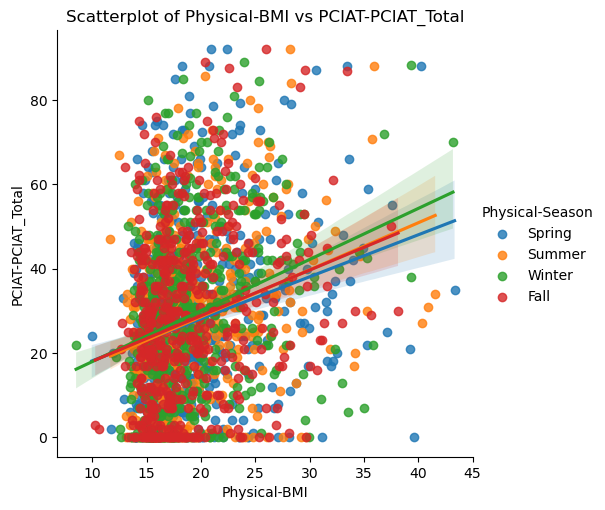

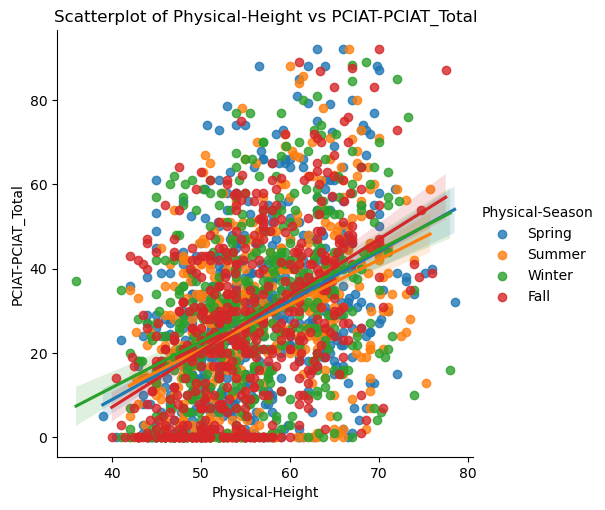

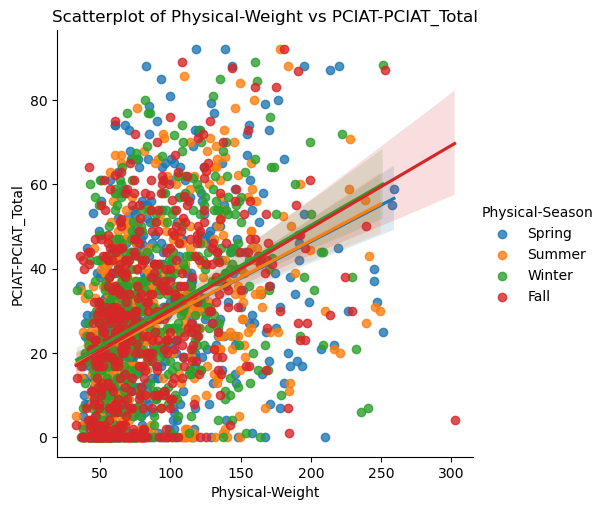

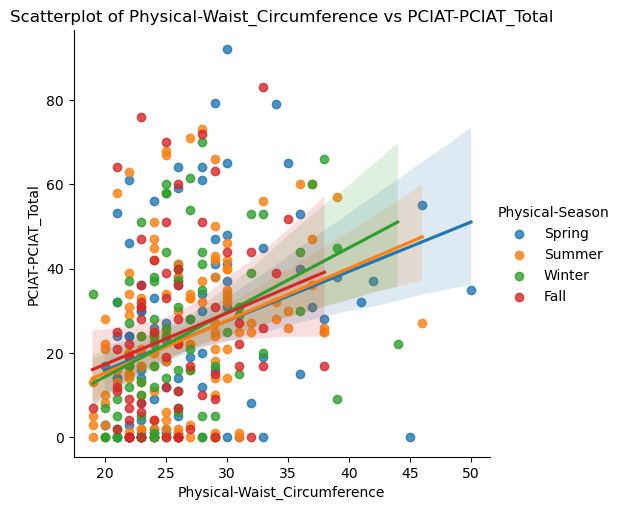

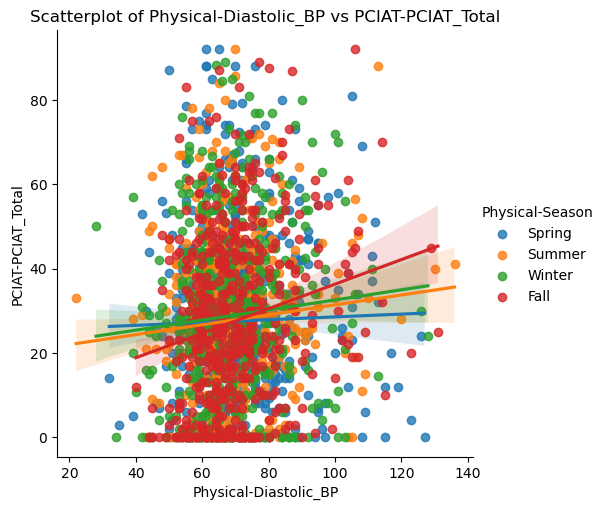

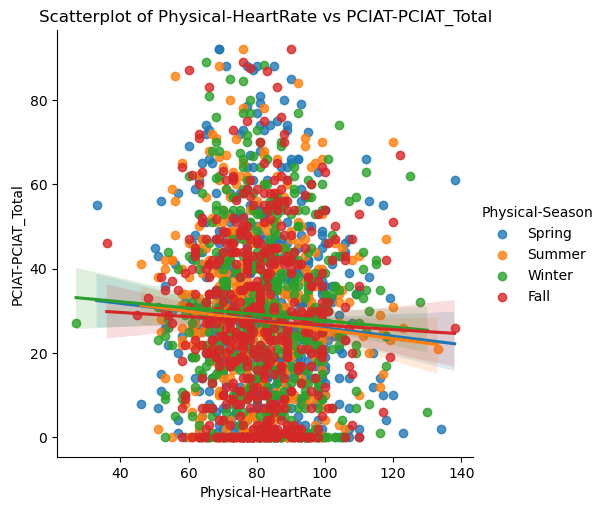

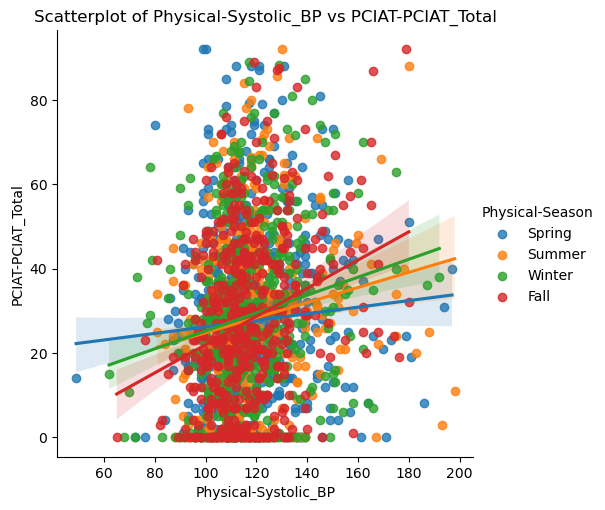

In [8]:
# For each variable in physical_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by Physical-Season. Add a line of best fit for each value of Physical-Season
for feature in physical_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='Physical-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There do appear to be some small effects of season on the extent to which the physical variables predict PCIAT scores. However, there don't appear to be particularly strong patterns in the data.

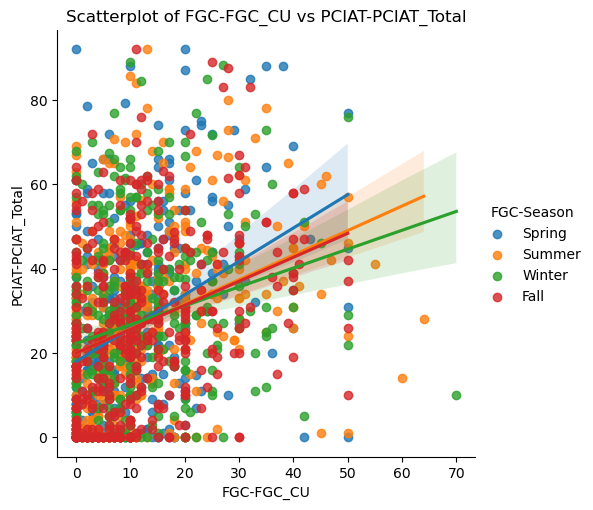

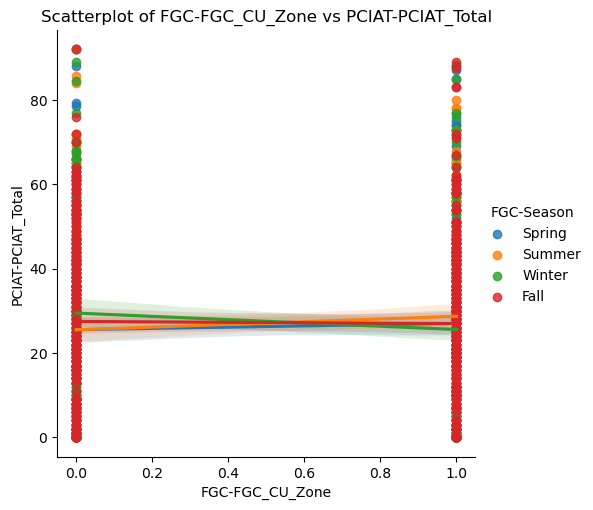

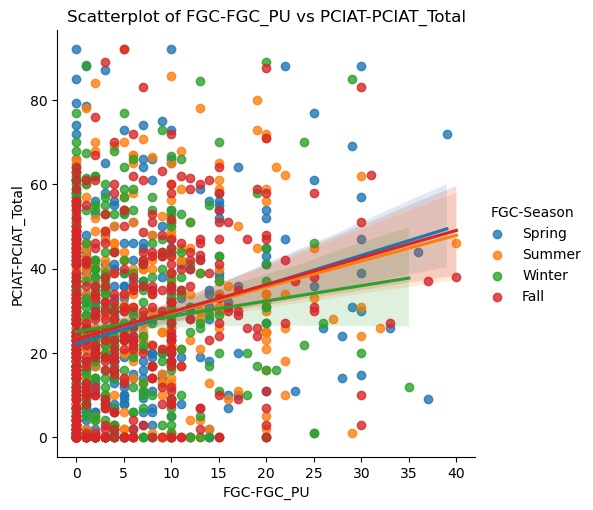

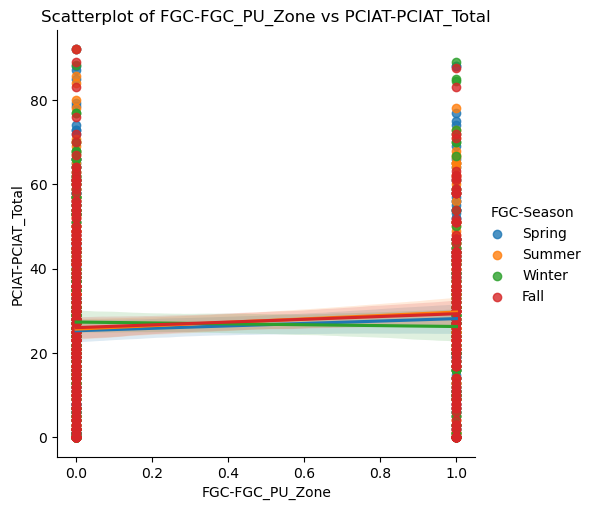

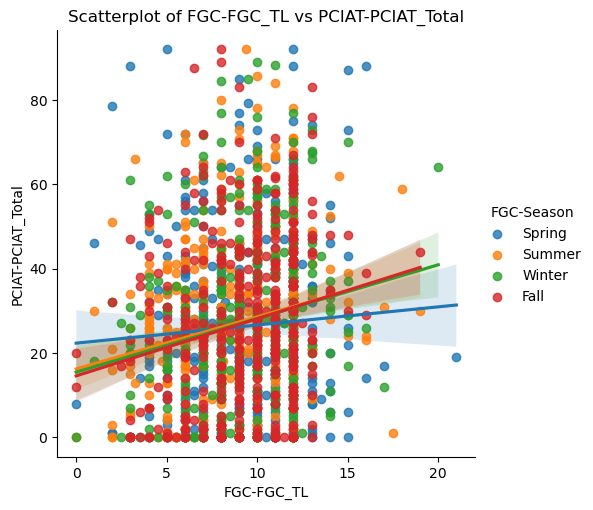

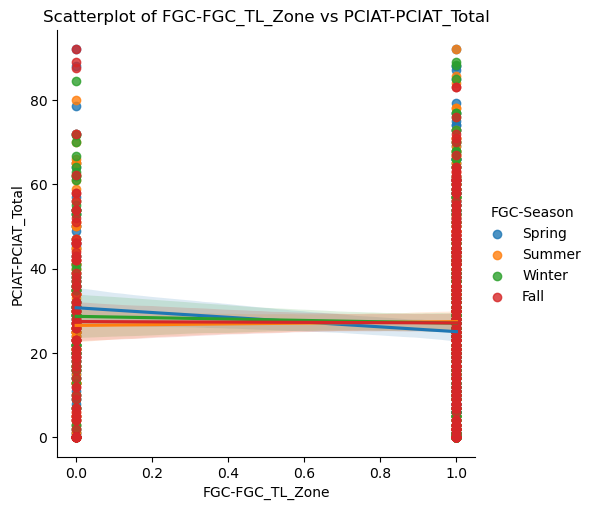

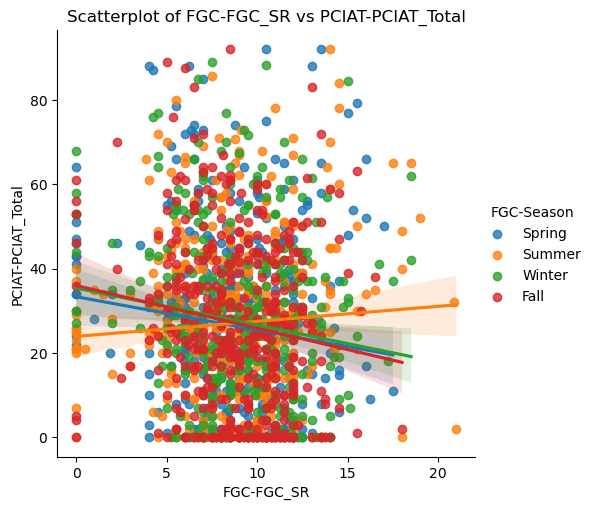

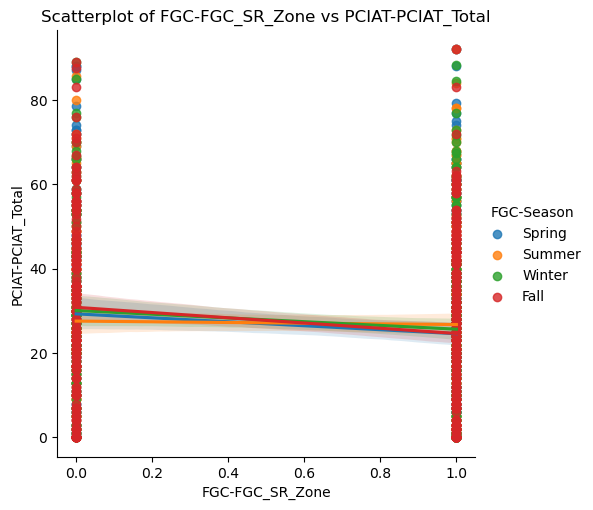

In [9]:
# For each variable in FGC_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by FGC-Season. Add a line of best fit for each value of FGC-Season
for feature in FGC_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='FGC-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There appears to be a slight effect of season on the sit & reach test prediction of PCIAT

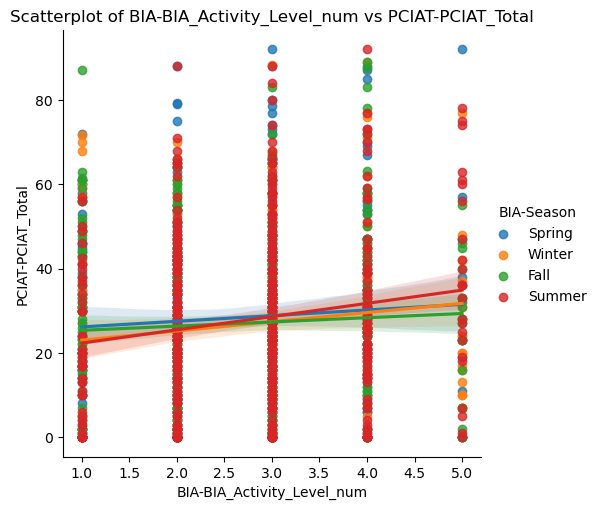

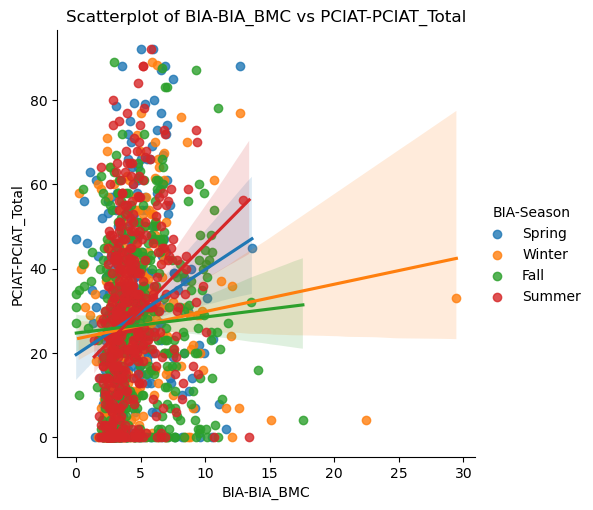

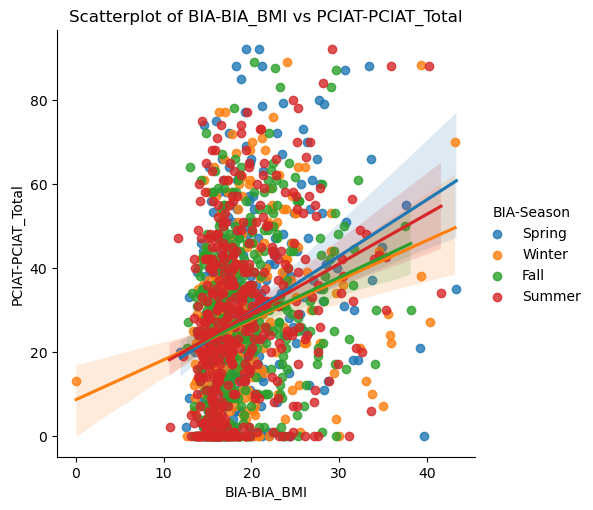

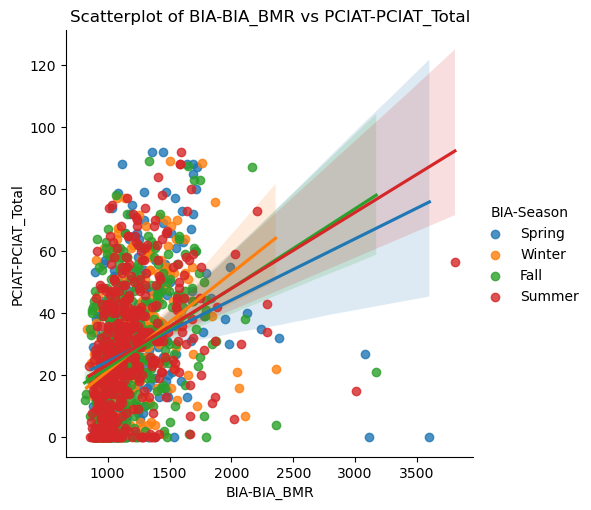

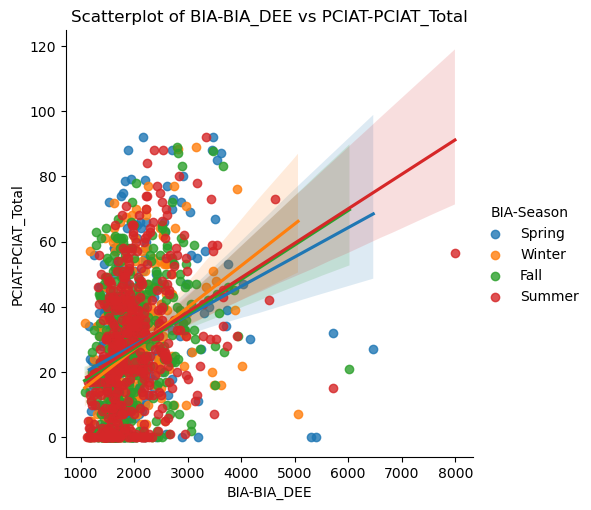

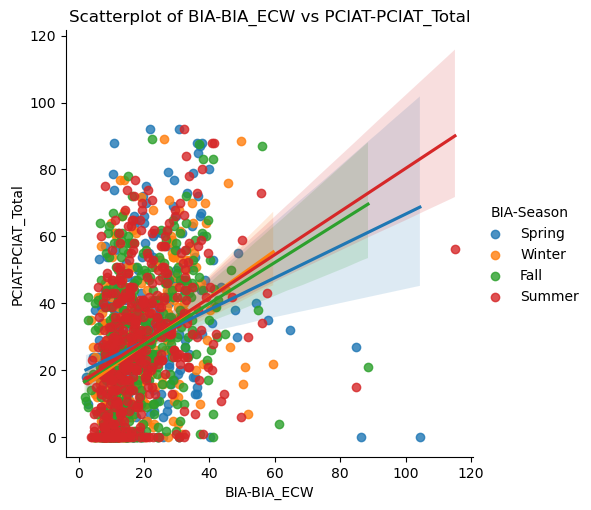

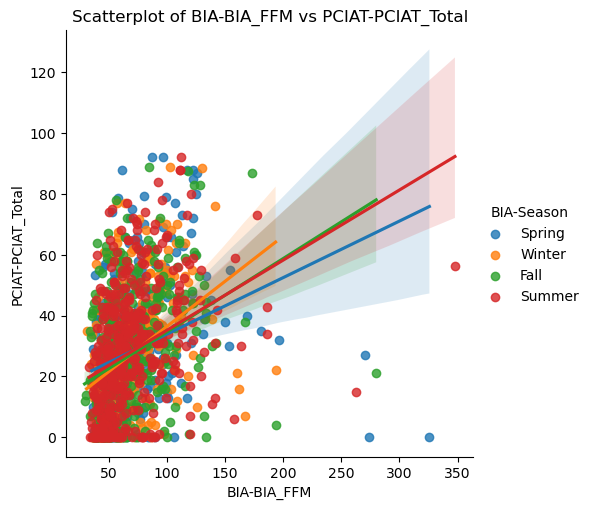

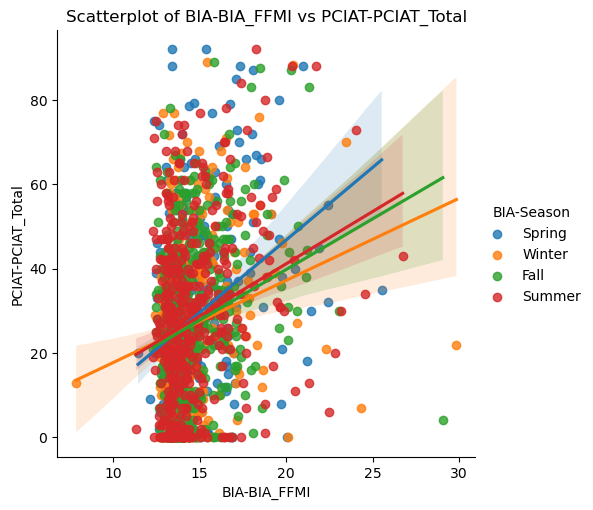

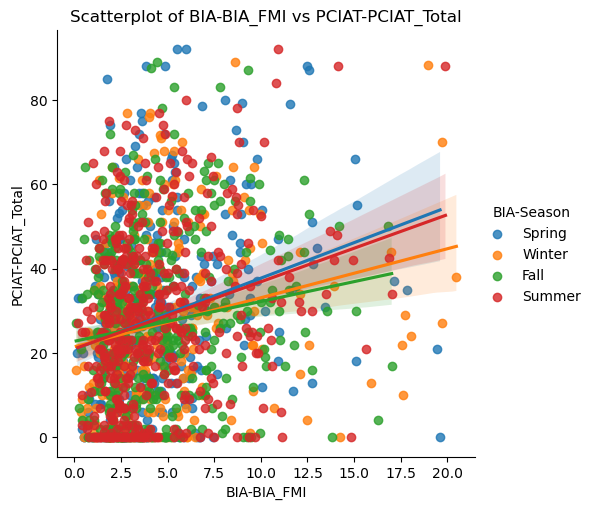

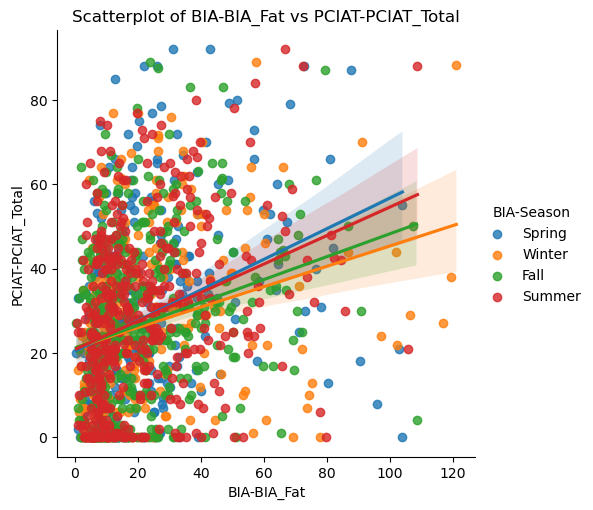

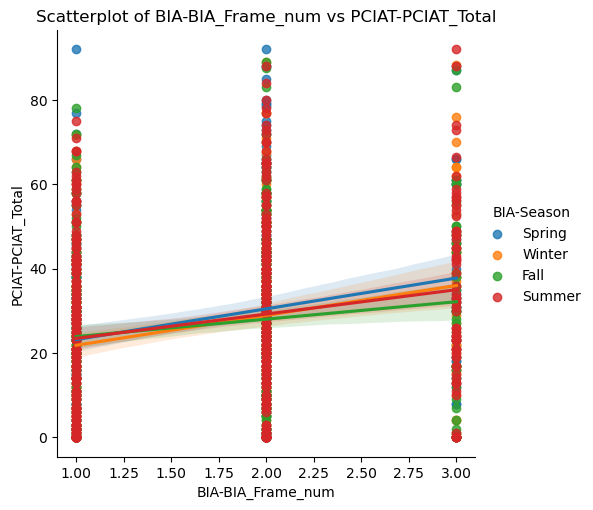

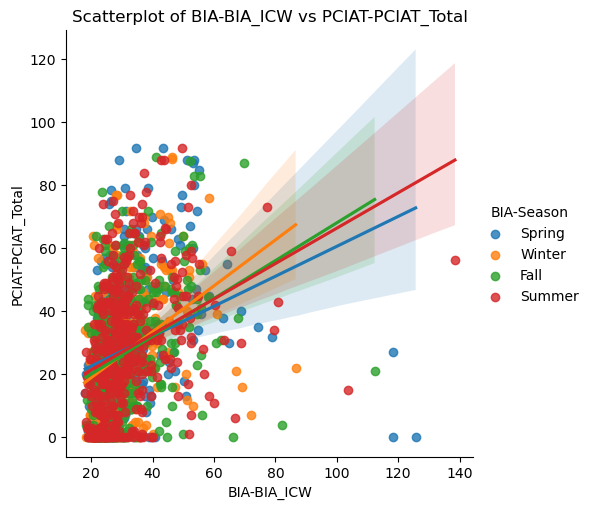

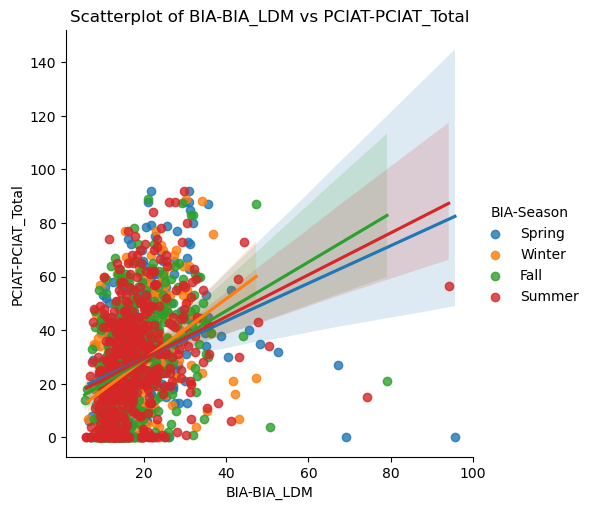

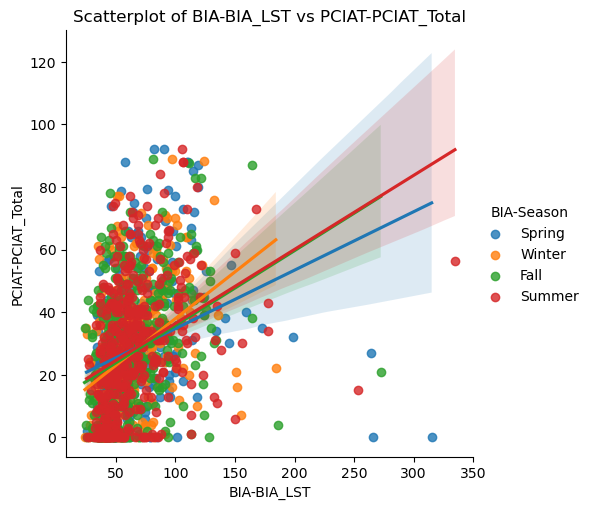

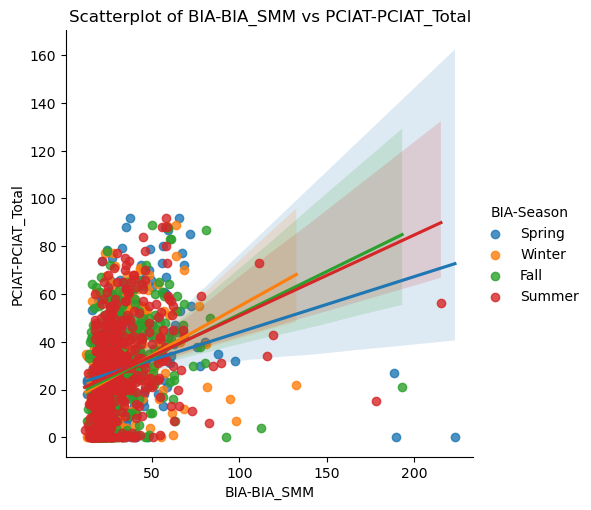

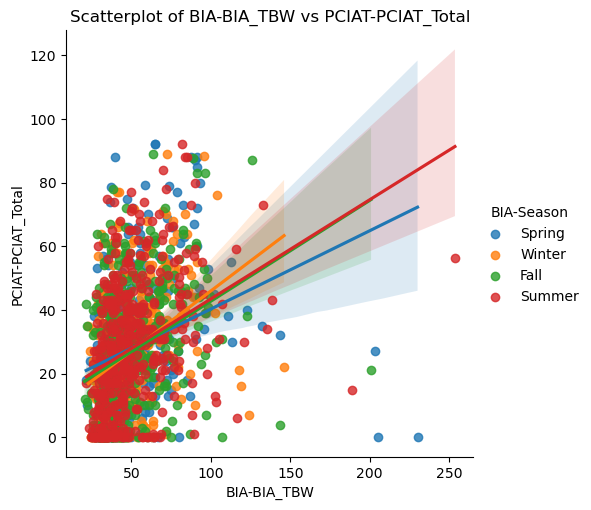

In [10]:
# For each variable in BIA_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by . Add a line of best fit for each value of BIA-Season
for feature in BIA_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='BIA-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There doesn't appear to be any interaction between the BIA variables and season.

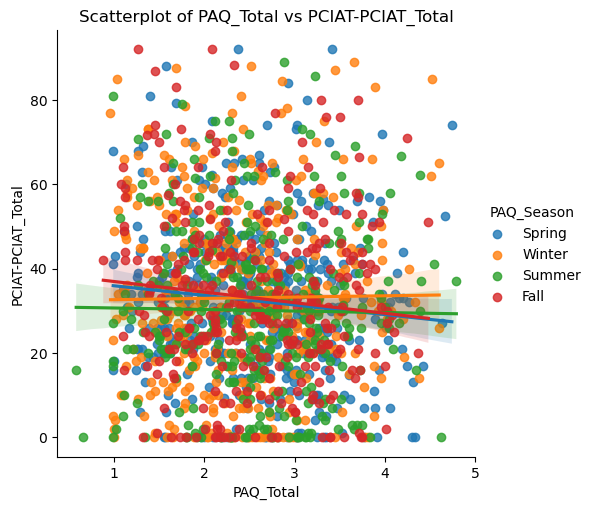

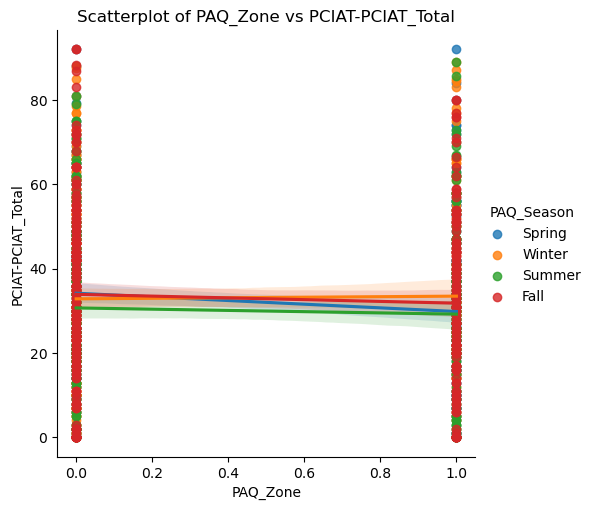

In [11]:
# For each variable in PAQ_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by PAQ-Season. Add a line of best fit for each value of PAQ_Season
for feature in PAQ_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='PAQ_Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There doesn't appear to be any interaction between season and the predictive power of PAQ scores.

**Overall Discussion of Season Interactions**

There don't appear to be many (if any) interactions between the Season variable and other predictor variables. We note that PCIAT also has a season variable, which would require further exploration.

It also seems possible that there might be some sort of "cohorting" effect - that is, for groups of participants who all got the same collection of measures in the same seasonal order. But identifying these effects is going to be beyond the scope of our exploration, so we will end up dropping the Season variables.

**Removing Features**

In this section, we'll remove all the features (identified above) that we think aren't necessary for constructing models

In [12]:
# Remove some variables we won't need

# Remove the variables 'id', 'BIA-BIA_BMI'
train_cleaned = train_cleaned.drop(['id', 'BIA-BIA_BMI'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, and FGC-FGC_TL_Zone
train_cleaned = train_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_TL_Zone'], axis=1)

# Remove the following variables from train: BIA-BIA_BMR, BIA-BIA_TBW, BIA-BIA_ECW, BIA-BIA_LDM, BIA-BIA_ICW, BIA-BIA_SMM, BIA-BIA_DEE, BIA-BIA_LST, and BIA-BIA_BMC
train_cleaned=train_cleaned.drop(columns=['BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_ECW', 'BIA-BIA_LDM', 'BIA-BIA_ICW', 'BIA-BIA_SMM', 'BIA-BIA_DEE', 'BIA-BIA_LST', 'BIA-BIA_BMC'])

# Remove the Fitness_Endurance-Max_Stage variable (based on previous exploration)
train_cleaned = train_cleaned.drop(['Fitness_Endurance-Max_Stage'], axis=1)

# Remove all variables with Season in their name
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.contains('Season')]

In [13]:
#We also remove these variables from the test data.

# Remove the variables 'id', 'BIA-BIA_BMI'
test_cleaned = test_cleaned.drop(['id', 'BIA-BIA_BMI'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, and FGC-FGC_TL_Zone
test_cleaned = test_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_TL_Zone'], axis=1)

# Remove the following variables from train: BIA-BIA_BMR, BIA-BIA_TBW, BIA-BIA_ECW, BIA-BIA_LDM, BIA-BIA_ICW, BIA-BIA_SMM, BIA-BIA_DEE, BIA-BIA_LST, and BIA-BIA_BMC
test_cleaned=test_cleaned.drop(columns=['BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_ECW', 'BIA-BIA_LDM', 'BIA-BIA_ICW', 'BIA-BIA_SMM', 'BIA-BIA_DEE', 'BIA-BIA_LST', 'BIA-BIA_BMC'])

# Remove the Fitness_Endurance-Max_Stage variable (based on previous exploration)
test_cleaned = test_cleaned.drop(['Fitness_Endurance-Max_Stage'], axis=1)

# Remove all variables with Season in their name
test_cleaned = test_cleaned.loc[:,~test_cleaned.columns.str.contains('Season')]

**Export the Feature-Selected Predictors**

In [15]:
# Export train_cleaned to a csv named train_cleaned_feature_selected.csv
train_cleaned.to_csv('train_cleaned_outcome_imputed_feature_selected.csv', index=False)
test_cleaned.to_csv('test_cleaned_feature_selected.csv', index=False)